In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

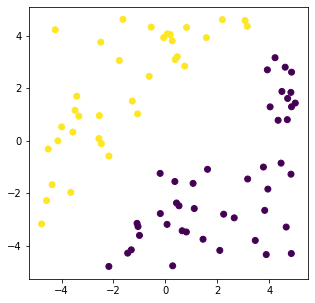

In [13]:
x = np.random.uniform(-5, 5, (2, 100))
x = x[:, np.logical_not((x[1, :] > x[0, :] -1) * (x[1, :] < x[0, :] +1))]
y = np.ones(x.shape[1])
y = np.where(x[1, :] > x[0, :], y, -1) # top left is positive
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x[0, :], x[1, :], c=y)
plt.show()

In [14]:
def plot_decision_boundary(x, y, w, b, sv=None, kernel=None, alpha=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x[0, :], x[1, :], c=y)
    ax.arrow(-b*(w[0]), -b*(w[1]), w[0], w[1], width=0.1, length_includes_head=True)
    if sv is not None:
        ax.scatter(x[0, sv], x[1, sv], marker='x')
    xx, yy = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
    if kernel is None:
        Z = np.where(np.dot(np.c_[xx.ravel(), yy.ravel()], w.reshape(-1, 1)) + b > 0, 1, -1)
    else:
        Z = np.where((y[sv]*res.x[sv]*kernel(np.c_[xx.ravel(), yy.ravel()].T, x[:, sv])).sum(1) > 0, 1, -1)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.1)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    plt.show()

### Hard margin

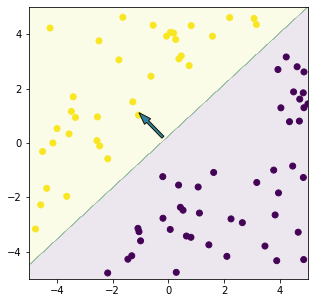

In [15]:
w = np.random.uniform(-2, 2, (x.shape[0], 1))
b = np.random.uniform(-2, 2, (1, 1))
var0 = np.concatenate((w, b))
ob_fun = lambda var: 0.5 * var[:2].T @ var[:2]
constr = lambda var, x, y: np.concatenate((np.diag(y) @ x.T, y.reshape(-1, 1)), 1) @ var -1
res = minimize(ob_fun, var0, constraints={"type": "ineq", "fun": constr, "args": (x, y)})
if res.success:
    w = res.x[:2]
    b = res.x[2]
    plot_decision_boundary(x, y, w, b)

### Soft margin

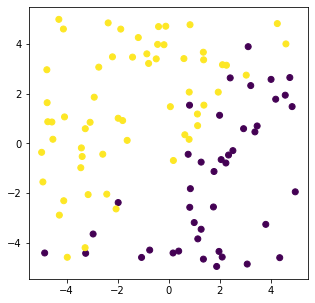

In [16]:
x = np.random.uniform(-5, 5, (2, 100))
y = np.ones(x.shape[1])
y = np.where(x[1, :] > x[0, :], y, -1) # top left is positive
y = np.where((x[1, :] > x[0, :] -1) * (x[1, :] < x[0, :] +1), np.random.choice([-1, 1], len(y)), y)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x[0, :], x[1, :], c=y)
plt.show()

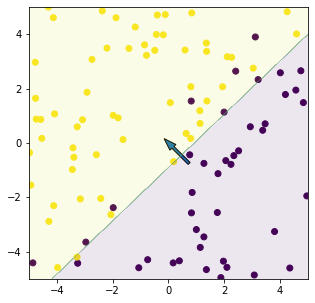

In [19]:
w = np.random.uniform(-2, 2, (x.shape[0], 1))
b = np.random.uniform(-2, 2, (1, 1))
xi = np.zeros_like(y).reshape(-1, 1)
var0 = np.concatenate((w, b, xi))
ob_fun = lambda var, C: 0.5 * var[:2].T @ var[:2] + C * var[3:].sum()
constr = lambda var, x, y: np.concatenate((np.diag(y) @ x.T, y.reshape(-1, 1)), 1) @ var[:3] +var[3:] -1
slack_con = lambda var: var[3:]
C = 5
res = minimize(ob_fun, var0, args=C, constraints=[{"type": "ineq", "fun": constr, "args": (x, y)},
                                                    {"type": "ineq", "fun": slack_con}])
if res.success:
    w = res.x[:2]
    b = res.x[2]
    plot_decision_boundary(x, y, w, b)

else:
    print(":(")

### Dual SVM

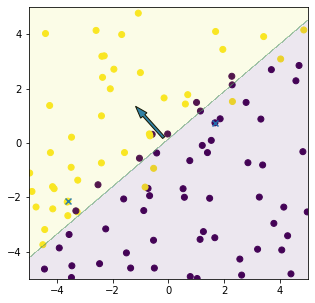

In [7]:
C = 1
K = np.dot(x.T, x)
alpha = np.random.uniform(0, C, (len(y), 1))
ob_fun = lambda var, y, K: 0.5 * var.T @ np.diag(y) @ K @ np.diag(y) @ var - var.sum()
eq_constr = lambda var, y: y @ var
res = minimize(ob_fun,
               alpha,
               args=(y, K),
               constraints=[{"type": "eq", "fun": eq_constr, "args": y.reshape(1, -1)},
                            {"type": "ineq", "fun": lambda var: var},
                            {"type": "ineq", "fun": lambda var, C: C - var, "args": [C]},
                            ]
               )
if res.success:
    w = x @ (res.x * y).reshape(-1, 1)
    sv = ((res.x > 0.01) * (res.x <= C)).nonzero()[0]
    b = y[sv[0]] - np.dot(w.T, x[:, sv[0]].reshape(-1, 1)).item()
    plot_decision_boundary(x, y, w.flatten(), b, sv)
else:
    print(":(")

### Kernel SVM

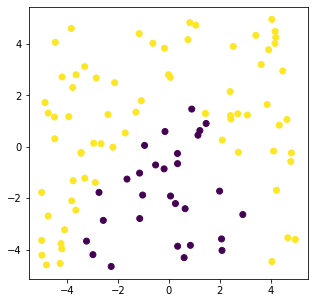

In [8]:
x = np.random.uniform(-5, 5, (2, 100))
y = np.ones(x.shape[1])
y = np.where(x[1, :] > -0.5*x[0, :]**2+2, y, -1) # top left is positive
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x[0, :], x[1, :], c=y)
plt.show()

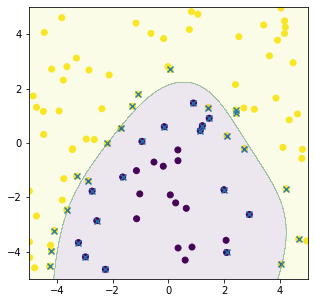

In [11]:
C = 1
gamma = 0.1
kernel = lambda x1, x2: np.exp(-gamma * cdist(x1.T, x2.T)**2)
#alpha = np.random.uniform(0, C, (len(y), 1))
alpha = np.zeros((len(y), 1))
ob_fun = lambda var, y, K: 0.5 * var.T @ np.diag(y) @ K @ np.diag(y) @ var - var.sum()
eq_constr = lambda var, y: y @ var
res = minimize(ob_fun,
               alpha,
               args=(y, kernel(x, x)),
               constraints=[{"type": "eq", "fun": eq_constr, "args": y.reshape(1, -1)},
                            {"type": "ineq", "fun": lambda var: var},
                            {"type": "ineq", "fun": lambda var, C: C - var, "args": [C]},
                            ]
               )
if res.success:
    w = x @ (res.x * y).reshape(-1, 1)
    sv = ((res.x > 0.01) * (res.x <= C)).nonzero()[0]
    b = y[sv[0]] - np.dot(w.T, x[:, sv[0]].reshape(-1, 1)).item()
    plot_decision_boundary(x, y, w.flatten(), b, sv, kernel, res.x)
else:
    print(":(")